# Paths

In [1]:
dataset_path = "./datasets/SimpleSoyBean"
tensorboard_path = "logs/"
models_path = "./models/SoyBean/"

# Dataloader

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def my_tensor_image_show ( image , label=None ):
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.axis('off')
    if label is None :
        plt.title('Image in tensor format.')
    else :
        plt.title(f'Image in tensor format | Class: {label:2d}')
    plt.show()    

In [3]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

def train_test_dataset(dataset, test_split=0.25):
    train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=test_split)
    train_data = Subset(dataset, train_idx)
    test_data = Subset(dataset, test_idx)
    return train_data, test_data

In [4]:
from torchvision.models import resnet101, ResNet101_Weights
my_transform = ResNet101_Weights.IMAGENET1K_V1.transforms()

In [5]:
import torch
import torchvision

data = torchvision.datasets.ImageFolder(root=dataset_path, transform=my_transform)

train_data, test_data = train_test_dataset(data, 0.30)

batch_size = 128

train_tensors = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_tensors = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

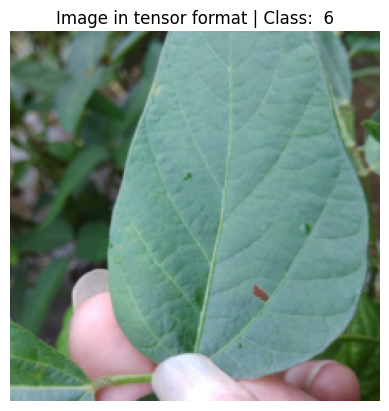

In [6]:
images, labels = next(iter(train_tensors))
my_tensor_image_show(images[0], label=labels[0])

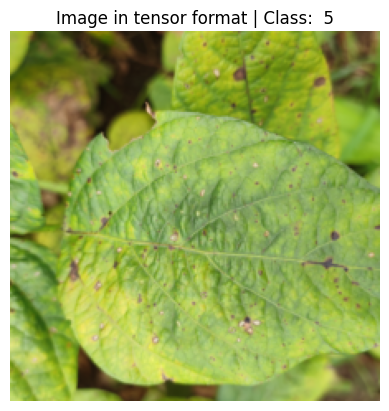

In [7]:
images, labels = next(iter(test_tensors))
my_tensor_image_show(images[0], label=labels[0])

# Training

In [8]:
from torch.utils.tensorboard import SummaryWriter

import torch.optim 
import matplotlib.pyplot as plt
  
from datetime import datetime

from tqdm import tqdm

import copy

def plot_layers ( net , writer, epoch ) :
    layers = list(net.fc.modules())
    
    layer_id = 1
    for layer in layers:
        if isinstance(layer, torch.nn.Linear) :

#             writer.add_histogram('Bias/conv{}'.format(layer_id), layer.bias, 
#                                 epoch )
            writer.add_histogram('Weight/conv{}'.format(layer_id), layer.weight, 
                                epoch )
#             writer.add_histogram('Grad/conv{}'.format(layer_id), layer.weight.grad, 
#                                     epoch )
            layer_id += 1


def train ( train_loader, test_loader, net, dataset_size, my_device='cpu',
           prefix=None, upper_bound=100.0, save=False, epochs=100, 
           lr=1e-1, device='cpu', debug=False, layers2tensorboard=False , batch_size=64) :

    optimizer = torch.optim.Adam(net.parameters(),lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    
    now = datetime.now()
    suffix = now.strftime("%Y%m%d_%H%M%S")
    prefix = suffix if prefix is None else prefix + '-' + suffix  

    writer = SummaryWriter( log_dir=tensorboard_path+prefix )
        
    accuracies = []
    max_accuracy = -1.0  

    for inputs, labels in train_loader:
        print("Labels:", labels.unique())
        break


    for epoch in tqdm(range(epochs), desc='Training epochs...') :
        net.train()
        for idx, (train_x, train_label) in enumerate(train_loader):
            train_x = train_x.to(device)
            train_label = train_label.to(device)

            predict_y = net( train_x )
            
            # Loss:
            error = criterion( predict_y , train_label )

            writer.add_scalar( 'Loss/train', error.cpu().item(), 
                                idx+( epoch*(dataset_size//batch_size) ) )

            # Back propagation
            optimizer.zero_grad()
            error.backward()
            optimizer.step()
            
            # Accuracy:
            predict_ys = torch.max( predict_y, axis=1 )[1]
            correct    = torch.sum(predict_ys == train_label)

            writer.add_scalar( 'Accuracy/train', correct/train_x.size(0), 
                                idx+( epoch*(dataset_size//batch_size) ) )

            if debug and idx % 10 == 0 :
                print( f'idx: {idx:4d}, _error: {error.cpu().item():5.2f}' )

        if layers2tensorboard :
            plot_layers( net, writer, epoch )

        accuracy = validate(net, test_loader, device=device)
        accuracies.append(accuracy)
        writer.add_scalar( 'Accuracy/test', accuracy, epoch )
        
        if accuracy > max_accuracy :
            best_model = copy.deepcopy(net)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        
        print( f'Epoch: {epoch+1:3d} | Accuracy : {accuracy:7.4f}%' )

        if accuracy > upper_bound :
            break
    
    if save : 
        path = f'{models_path}ResNet101-{dataset}-{max_accuracy:.2f}.pkl'
        torch.save(best_model, path)
        print('Model saved in:',path)
    
    plt.plot(accuracies)

    writer.flush()
    writer.close()
    
    return best_model    

# Validation

In [9]:
def validate ( model , data , device='cpu') :

    model.eval()

    correct = 0
    sum = 0
    
    for idx, (test_x, test_label) in enumerate(data) : 
        test_x = test_x.to(device)
        test_label = test_label.to(device)
        predict_y = model( test_x ).detach()
        predict_ys = torch.max( predict_y, axis=1 )[1]
        sum = sum + test_x.size(0)
        correct = correct + torch.sum(predict_ys == test_label)
        correct = correct.cpu().item()
    
    return correct*100./sum

# Run

In [10]:
import torch
from torchvision.models import resnet101

# arquivo com modelo treinado no dataset SoyNet
path = './models/SoyNet/ResNet101-SoyNet-95.98.pkl'

# carrega o modelo
modelResNetTL = torch.load(path, weights_only=False)

# verifica as camadas
for name, param in modelResNetTL.named_parameters():
    print(f"{name}")


conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.we

In [11]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

def train_test_dataset(dataset, test_split=0.25):
    train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=test_split)
    train_data = Subset(dataset, train_idx)
    test_data = Subset(dataset, test_idx)
    return train_data, test_data

In [12]:
for param in modelResNetTL.parameters():
    param.requires_grad = False

modelResNetTL.fc.requires_grad_(True)
# num_classes = 10
num_classes = 13
modelResNetTL.fc = torch.nn.Linear(modelResNetTL.fc.in_features, num_classes)

In [13]:
# Check which layers are frozen
for name, param in modelResNetTL.named_parameters():
    status = "Trainable" if param.requires_grad else "Frozen"
    print(f"{name}: {status}")

conv1.weight: Frozen
bn1.weight: Frozen
bn1.bias: Frozen
layer1.0.conv1.weight: Frozen
layer1.0.bn1.weight: Frozen
layer1.0.bn1.bias: Frozen
layer1.0.conv2.weight: Frozen
layer1.0.bn2.weight: Frozen
layer1.0.bn2.bias: Frozen
layer1.0.conv3.weight: Frozen
layer1.0.bn3.weight: Frozen
layer1.0.bn3.bias: Frozen
layer1.0.downsample.0.weight: Frozen
layer1.0.downsample.1.weight: Frozen
layer1.0.downsample.1.bias: Frozen
layer1.1.conv1.weight: Frozen
layer1.1.bn1.weight: Frozen
layer1.1.bn1.bias: Frozen
layer1.1.conv2.weight: Frozen
layer1.1.bn2.weight: Frozen
layer1.1.bn2.bias: Frozen
layer1.1.conv3.weight: Frozen
layer1.1.bn3.weight: Frozen
layer1.1.bn3.bias: Frozen
layer1.2.conv1.weight: Frozen
layer1.2.bn1.weight: Frozen
layer1.2.bn1.bias: Frozen
layer1.2.conv2.weight: Frozen
layer1.2.bn2.weight: Frozen
layer1.2.bn2.bias: Frozen
layer1.2.conv3.weight: Frozen
layer1.2.bn3.weight: Frozen
layer1.2.bn3.bias: Frozen
layer2.0.conv1.weight: Frozen
layer2.0.bn1.weight: Frozen
layer2.0.bn1.bias: F

Running on cuda
Labels: tensor([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12])


Training epochs...:   1%|          | 1/100 [03:52<6:24:26, 232.99s/it]

Saving Best Model with Accuracy:  13.675213675213675
Epoch:   1 | Accuracy : 13.6752%


Training epochs...:   2%|▏         | 2/100 [05:23<4:03:23, 149.01s/it]

Saving Best Model with Accuracy:  22.79202279202279
Epoch:   2 | Accuracy : 22.7920%


Training epochs...:   3%|▎         | 3/100 [06:54<3:18:06, 122.54s/it]

Saving Best Model with Accuracy:  33.04843304843305
Epoch:   3 | Accuracy : 33.0484%


Training epochs...:   4%|▍         | 4/100 [08:27<2:57:30, 110.94s/it]

Saving Best Model with Accuracy:  43.01994301994302
Epoch:   4 | Accuracy : 43.0199%


Training epochs...:   5%|▌         | 5/100 [09:59<2:45:03, 104.25s/it]

Saving Best Model with Accuracy:  49.572649572649574
Epoch:   5 | Accuracy : 49.5726%


Training epochs...:   6%|▌         | 6/100 [11:34<2:38:06, 100.92s/it]

Saving Best Model with Accuracy:  55.55555555555556
Epoch:   6 | Accuracy : 55.5556%


Training epochs...:   7%|▋         | 7/100 [13:07<2:32:43, 98.54s/it] 

Saving Best Model with Accuracy:  58.68945868945869
Epoch:   7 | Accuracy : 58.6895%


Training epochs...:   8%|▊         | 8/100 [14:42<2:29:01, 97.19s/it]

Saving Best Model with Accuracy:  60.68376068376068
Epoch:   8 | Accuracy : 60.6838%


Training epochs...:   9%|▉         | 9/100 [16:15<2:25:38, 96.03s/it]

Saving Best Model with Accuracy:  61.25356125356125
Epoch:   9 | Accuracy : 61.2536%


Training epochs...:  10%|█         | 10/100 [17:44<2:20:50, 93.89s/it]

Saving Best Model with Accuracy:  62.96296296296296
Epoch:  10 | Accuracy : 62.9630%


Training epochs...:  11%|█         | 11/100 [19:15<2:17:50, 92.93s/it]

Saving Best Model with Accuracy:  65.8119658119658
Epoch:  11 | Accuracy : 65.8120%


Training epochs...:  12%|█▏        | 12/100 [20:44<2:14:23, 91.63s/it]

Saving Best Model with Accuracy:  66.95156695156695
Epoch:  12 | Accuracy : 66.9516%


Training epochs...:  13%|█▎        | 13/100 [22:12<2:11:35, 90.76s/it]

Epoch:  13 | Accuracy : 66.9516%


Training epochs...:  14%|█▍        | 14/100 [23:40<2:08:54, 89.93s/it]

Saving Best Model with Accuracy:  68.09116809116809
Epoch:  14 | Accuracy : 68.0912%


Training epochs...:  15%|█▌        | 15/100 [25:08<2:06:21, 89.19s/it]

Saving Best Model with Accuracy:  70.94017094017094
Epoch:  15 | Accuracy : 70.9402%


Training epochs...:  16%|█▌        | 16/100 [26:36<2:04:27, 88.90s/it]

Epoch:  16 | Accuracy : 70.3704%


Training epochs...:  17%|█▋        | 17/100 [28:03<2:02:17, 88.40s/it]

Epoch:  17 | Accuracy : 69.8006%


Training epochs...:  18%|█▊        | 18/100 [29:32<2:00:50, 88.42s/it]

Saving Best Model with Accuracy:  72.07977207977208
Epoch:  18 | Accuracy : 72.0798%


Training epochs...:  19%|█▉        | 19/100 [31:01<1:59:30, 88.52s/it]

Saving Best Model with Accuracy:  73.5042735042735
Epoch:  19 | Accuracy : 73.5043%


Training epochs...:  20%|██        | 20/100 [32:29<1:57:52, 88.41s/it]

Epoch:  20 | Accuracy : 72.6496%


Training epochs...:  21%|██        | 21/100 [33:56<1:56:01, 88.12s/it]

Epoch:  21 | Accuracy : 72.6496%


Training epochs...:  22%|██▏       | 22/100 [35:24<1:54:16, 87.90s/it]

Saving Best Model with Accuracy:  73.78917378917379
Epoch:  22 | Accuracy : 73.7892%


Training epochs...:  23%|██▎       | 23/100 [36:52<1:53:02, 88.09s/it]

Saving Best Model with Accuracy:  74.35897435897436
Epoch:  23 | Accuracy : 74.3590%


Training epochs...:  24%|██▍       | 24/100 [38:19<1:51:05, 87.70s/it]

Saving Best Model with Accuracy:  74.64387464387464
Epoch:  24 | Accuracy : 74.6439%


Training epochs...:  25%|██▌       | 25/100 [39:46<1:49:30, 87.61s/it]

Saving Best Model with Accuracy:  76.35327635327636
Epoch:  25 | Accuracy : 76.3533%


Training epochs...:  26%|██▌       | 26/100 [41:13<1:47:48, 87.41s/it]

Epoch:  26 | Accuracy : 75.7835%


Training epochs...:  27%|██▋       | 27/100 [42:40<1:46:01, 87.15s/it]

Epoch:  27 | Accuracy : 76.3533%


Training epochs...:  28%|██▊       | 28/100 [44:06<1:44:13, 86.85s/it]

Epoch:  28 | Accuracy : 74.6439%


Training epochs...:  29%|██▉       | 29/100 [45:33<1:42:43, 86.81s/it]

Epoch:  29 | Accuracy : 75.4986%


Training epochs...:  30%|███       | 30/100 [46:59<1:41:01, 86.59s/it]

Epoch:  30 | Accuracy : 76.3533%


Training epochs...:  31%|███       | 31/100 [48:25<1:39:23, 86.43s/it]

Saving Best Model with Accuracy:  76.63817663817663
Epoch:  31 | Accuracy : 76.6382%


Training epochs...:  32%|███▏      | 32/100 [49:52<1:38:05, 86.55s/it]

Epoch:  32 | Accuracy : 76.0684%


Training epochs...:  33%|███▎      | 33/100 [51:16<1:35:54, 85.88s/it]

Epoch:  33 | Accuracy : 76.3533%


Training epochs...:  34%|███▍      | 34/100 [52:37<1:32:47, 84.36s/it]

Epoch:  34 | Accuracy : 76.6382%


Training epochs...:  35%|███▌      | 35/100 [53:57<1:30:03, 83.14s/it]

Saving Best Model with Accuracy:  76.92307692307692
Epoch:  35 | Accuracy : 76.9231%


Training epochs...:  36%|███▌      | 36/100 [55:18<1:28:04, 82.57s/it]

Epoch:  36 | Accuracy : 76.6382%


Training epochs...:  37%|███▋      | 37/100 [56:40<1:26:25, 82.31s/it]

Epoch:  37 | Accuracy : 76.6382%


Training epochs...:  38%|███▊      | 38/100 [58:03<1:25:09, 82.41s/it]

Epoch:  38 | Accuracy : 76.0684%


Training epochs...:  39%|███▉      | 39/100 [59:30<1:25:09, 83.76s/it]

Saving Best Model with Accuracy:  77.77777777777777
Epoch:  39 | Accuracy : 77.7778%


Training epochs...:  40%|████      | 40/100 [1:00:56<1:24:26, 84.44s/it]

Saving Best Model with Accuracy:  78.06267806267806
Epoch:  40 | Accuracy : 78.0627%


Training epochs...:  41%|████      | 41/100 [1:02:22<1:23:36, 85.02s/it]

Epoch:  41 | Accuracy : 78.0627%


Training epochs...:  42%|████▏     | 42/100 [1:03:48<1:22:36, 85.46s/it]

Epoch:  42 | Accuracy : 76.9231%


Training epochs...:  43%|████▎     | 43/100 [1:05:15<1:21:21, 85.63s/it]

Epoch:  43 | Accuracy : 76.9231%


Training epochs...:  44%|████▍     | 44/100 [1:06:40<1:20:00, 85.72s/it]

Epoch:  44 | Accuracy : 77.7778%


Training epochs...:  45%|████▌     | 45/100 [1:08:07<1:18:46, 85.94s/it]

Epoch:  45 | Accuracy : 77.7778%


Training epochs...:  46%|████▌     | 46/100 [1:09:33<1:17:28, 86.08s/it]

Epoch:  46 | Accuracy : 77.7778%


Training epochs...:  47%|████▋     | 47/100 [1:11:00<1:16:12, 86.27s/it]

Epoch:  47 | Accuracy : 78.0627%


Training epochs...:  48%|████▊     | 48/100 [1:12:26<1:14:47, 86.29s/it]

Epoch:  48 | Accuracy : 77.7778%


Training epochs...:  49%|████▉     | 49/100 [1:13:52<1:13:18, 86.25s/it]

Epoch:  49 | Accuracy : 77.4929%


Training epochs...:  50%|█████     | 50/100 [1:15:19<1:11:59, 86.38s/it]

Saving Best Model with Accuracy:  78.34757834757835
Epoch:  50 | Accuracy : 78.3476%


Training epochs...:  51%|█████     | 51/100 [1:16:45<1:10:31, 86.35s/it]

Epoch:  51 | Accuracy : 78.3476%


Training epochs...:  52%|█████▏    | 52/100 [1:18:12<1:09:04, 86.34s/it]

Epoch:  52 | Accuracy : 78.0627%


Training epochs...:  53%|█████▎    | 53/100 [1:19:39<1:07:44, 86.48s/it]

Epoch:  53 | Accuracy : 78.0627%


Training epochs...:  54%|█████▍    | 54/100 [1:21:05<1:06:18, 86.49s/it]

Saving Best Model with Accuracy:  78.63247863247864
Epoch:  54 | Accuracy : 78.6325%


Training epochs...:  55%|█████▌    | 55/100 [1:22:32<1:05:00, 86.69s/it]

Epoch:  55 | Accuracy : 78.6325%


Training epochs...:  56%|█████▌    | 56/100 [1:23:58<1:03:26, 86.52s/it]

Epoch:  56 | Accuracy : 78.0627%


Training epochs...:  57%|█████▋    | 57/100 [1:25:24<1:01:54, 86.39s/it]

Epoch:  57 | Accuracy : 78.0627%


Training epochs...:  58%|█████▊    | 58/100 [1:26:51<1:00:27, 86.38s/it]

Epoch:  58 | Accuracy : 77.7778%


Training epochs...:  59%|█████▉    | 59/100 [1:28:17<59:02, 86.40s/it]  

Epoch:  59 | Accuracy : 77.4929%


Training epochs...:  60%|██████    | 60/100 [1:29:44<57:43, 86.58s/it]

Epoch:  60 | Accuracy : 78.0627%


Training epochs...:  61%|██████    | 61/100 [1:31:10<56:11, 86.46s/it]

Saving Best Model with Accuracy:  78.91737891737891
Epoch:  61 | Accuracy : 78.9174%


Training epochs...:  62%|██████▏   | 62/100 [1:32:37<54:48, 86.55s/it]

Saving Best Model with Accuracy:  79.48717948717949
Epoch:  62 | Accuracy : 79.4872%


Training epochs...:  63%|██████▎   | 63/100 [1:34:03<53:19, 86.47s/it]

Epoch:  63 | Accuracy : 78.0627%


Training epochs...:  64%|██████▍   | 64/100 [1:35:30<51:55, 86.55s/it]

Epoch:  64 | Accuracy : 78.6325%


Training epochs...:  65%|██████▌   | 65/100 [1:36:57<50:31, 86.61s/it]

Epoch:  65 | Accuracy : 78.9174%


Training epochs...:  66%|██████▌   | 66/100 [1:38:23<49:02, 86.54s/it]

Epoch:  66 | Accuracy : 78.9174%


Training epochs...:  67%|██████▋   | 67/100 [1:39:50<47:33, 86.47s/it]

Epoch:  67 | Accuracy : 79.2023%


Training epochs...:  68%|██████▊   | 68/100 [1:41:16<46:05, 86.43s/it]

Saving Best Model with Accuracy:  79.77207977207978
Epoch:  68 | Accuracy : 79.7721%


Training epochs...:  69%|██████▉   | 69/100 [1:42:43<44:43, 86.55s/it]

Epoch:  69 | Accuracy : 78.9174%


Training epochs...:  70%|███████   | 70/100 [1:44:10<43:17, 86.59s/it]

Epoch:  70 | Accuracy : 78.3476%


Training epochs...:  71%|███████   | 71/100 [1:45:36<41:47, 86.48s/it]

Epoch:  71 | Accuracy : 79.2023%


Training epochs...:  72%|███████▏  | 72/100 [1:47:02<40:23, 86.55s/it]

Saving Best Model with Accuracy:  80.34188034188034
Epoch:  72 | Accuracy : 80.3419%


Training epochs...:  73%|███████▎  | 73/100 [1:48:29<38:59, 86.65s/it]

Epoch:  73 | Accuracy : 79.4872%


Training epochs...:  74%|███████▍  | 74/100 [1:49:56<37:33, 86.69s/it]

Epoch:  74 | Accuracy : 79.4872%


Training epochs...:  75%|███████▌  | 75/100 [1:51:23<36:08, 86.73s/it]

Epoch:  75 | Accuracy : 79.2023%


Training epochs...:  76%|███████▌  | 76/100 [1:52:50<34:40, 86.70s/it]

Epoch:  76 | Accuracy : 79.4872%


Training epochs...:  77%|███████▋  | 77/100 [1:54:16<33:12, 86.64s/it]

Epoch:  77 | Accuracy : 80.0570%


Training epochs...:  78%|███████▊  | 78/100 [1:55:43<31:45, 86.62s/it]

Epoch:  78 | Accuracy : 79.4872%


Training epochs...:  79%|███████▉  | 79/100 [1:57:10<30:23, 86.82s/it]

Epoch:  79 | Accuracy : 79.2023%


Training epochs...:  80%|████████  | 80/100 [1:58:36<28:53, 86.69s/it]

Epoch:  80 | Accuracy : 79.7721%


Training epochs...:  81%|████████  | 81/100 [2:00:03<27:26, 86.66s/it]

Epoch:  81 | Accuracy : 78.9174%


Training epochs...:  82%|████████▏ | 82/100 [2:01:29<25:59, 86.64s/it]

Epoch:  82 | Accuracy : 79.4872%


Training epochs...:  83%|████████▎ | 83/100 [2:02:56<24:32, 86.60s/it]

Epoch:  83 | Accuracy : 80.3419%


Training epochs...:  84%|████████▍ | 84/100 [2:04:23<23:05, 86.61s/it]

Epoch:  84 | Accuracy : 80.0570%


Training epochs...:  85%|████████▌ | 85/100 [2:05:49<21:39, 86.65s/it]

Epoch:  85 | Accuracy : 80.0570%


Training epochs...:  86%|████████▌ | 86/100 [2:07:16<20:12, 86.63s/it]

Epoch:  86 | Accuracy : 79.4872%


Training epochs...:  87%|████████▋ | 87/100 [2:08:42<18:45, 86.57s/it]

Epoch:  87 | Accuracy : 79.7721%


Training epochs...:  88%|████████▊ | 88/100 [2:10:09<17:19, 86.65s/it]

Saving Best Model with Accuracy:  80.62678062678063
Epoch:  88 | Accuracy : 80.6268%


Training epochs...:  89%|████████▉ | 89/100 [2:11:35<15:50, 86.45s/it]

Epoch:  89 | Accuracy : 80.0570%


Training epochs...:  90%|█████████ | 90/100 [2:13:01<14:23, 86.38s/it]

Epoch:  90 | Accuracy : 80.3419%


Training epochs...:  91%|█████████ | 91/100 [2:14:29<12:59, 86.63s/it]

Saving Best Model with Accuracy:  80.91168091168092
Epoch:  91 | Accuracy : 80.9117%


Training epochs...:  92%|█████████▏| 92/100 [2:15:55<11:32, 86.61s/it]

Epoch:  92 | Accuracy : 80.9117%


Training epochs...:  93%|█████████▎| 93/100 [2:17:21<10:05, 86.48s/it]

Epoch:  93 | Accuracy : 79.7721%


Training epochs...:  94%|█████████▍| 94/100 [2:18:48<08:39, 86.53s/it]

Epoch:  94 | Accuracy : 78.9174%


Training epochs...:  95%|█████████▌| 95/100 [2:20:15<07:14, 86.80s/it]

Saving Best Model with Accuracy:  81.19658119658119
Epoch:  95 | Accuracy : 81.1966%


Training epochs...:  96%|█████████▌| 96/100 [2:21:43<05:48, 87.07s/it]

Epoch:  96 | Accuracy : 80.9117%


Training epochs...:  97%|█████████▋| 97/100 [2:23:10<04:21, 87.06s/it]

Epoch:  97 | Accuracy : 80.9117%


Training epochs...:  98%|█████████▊| 98/100 [2:24:37<02:54, 87.13s/it]

Epoch:  98 | Accuracy : 78.9174%


Training epochs...:  99%|█████████▉| 99/100 [2:26:05<01:27, 87.15s/it]

Epoch:  99 | Accuracy : 80.0570%


Training epochs...: 100%|██████████| 100/100 [2:27:33<00:00, 88.53s/it]

Epoch: 100 | Accuracy : 79.4872%
Model saved in: ./models/SoyBean/ResNet101-SoyBean-81.20.pkl


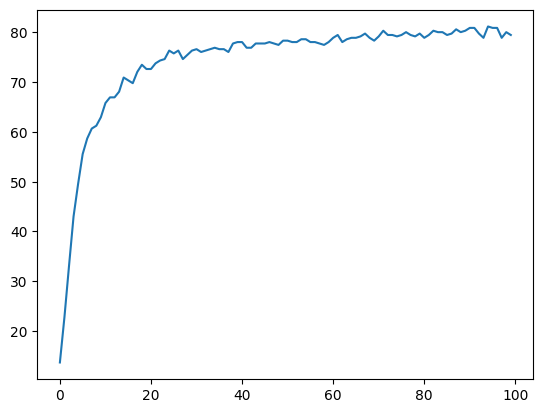

In [14]:
if torch.cuda.is_available():
    my_device = torch.device("cuda:0")
else:
    my_device = torch.device("cpu")

print(f"Running on {my_device.type}")
    
model = modelResNetTL.to(my_device)

epochs = 100
lr = 1e-4
dataset = 'SoyBean'
prefix = 'ResNet101-TL-{}-e-{}-lr-{}'.format(dataset, epochs, lr)

net = train(train_tensors, test_tensors, model, len(train_data),
            epochs=epochs, device=my_device, save=True, 
            prefix=prefix, lr=lr, layers2tensorboard=True, batch_size=batch_size)

Sample id: 300
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
Hit
2
Predicted: crestamento | Corrected: crestamento | Confidence: 41.71%


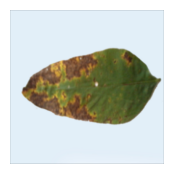

In [ ]:
def sample_and_predict ( net, seed=None ) :

    if seed is not None :
        np.random.seed(seed)

    dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=None)

    data = train_test_dataset(dataset, 0.30)[1]
    
    # my_transform = AlexNet_Weights.IMAGENET1K_V1.transforms()
    # my_transform = ResNet18_Weights.IMAGENET1K_V1.transforms()
    i = np.random.randint(len(data))
    
    sample = data[i][0]
    plt.figure(figsize=(2,2))
    plt.axis('off')
    plt.imshow( sample )

    print( f'Sample id: {i:3d}' )
    
    x = my_transform(sample)
    print(x.shape)

    x = x.unsqueeze_(0)
    print(x.shape)

    x = x.to(my_device)
    
    output = net ( x )
    predictions = output.squeeze(0).softmax(0)
        
    predicted_class = torch.argmax(predictions)
    predicted_class = predicted_class.data.cpu().item()
    
    confidence = predictions[predicted_class]
    confidence = confidence.data.cpu().item()
    
    dataset_classes = [
        "bacterial_blight", "brown_spot", "crestamento", "ferrugem", "mossaic_virus", "powdery_mildew",
        "septoria", "southern_blight", "sudden_death_syndrone", "yellow_mosaic"
    ]

    # dataset_classes = [
    #     "BacterialBlight", "BacterialPustule", "BrownSpot", "Crestamento", "Ferrugem", "FrogeyeLeafSpot",
    #     "Healthy", "PowderyMildew", "Rust", "Septoria", "SuddenDeathSyndrome", "TargetLeafSpot", "YellowMosaic"
    # ]

    if predicted_class == data[i][1] : print('Hit')
    else: print('Miss')

    print(predicted_class)
    print( f'Predicted: {dataset_classes[predicted_class]} | Corrected: {dataset_classes[data[i][1]]} | Confidence: {confidence*100:.2f}%'  )
    
    # return dataset_classes[y], dataset_classes[data[i][1]], confidence

sample_and_predict(net)
